In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.chdir('/Volumes/GoogleDrive/My Drive/BEAM-CORE/BEAM Validation')

plt.style.use('ggplot')

In [2]:
# load parameter and data for validation
meter_to_mile = 0.000621371
percent_of_samples = 1
mps_to_mph = 2.23694
scenario_name = 'Oakland2021'
modeled_vmt = read_csv('sample output/Oakland2021/0.linkstats.csv.gz', low_memory=False)
observed_vmt = read_csv('data for validation/SF/VMT/oakland_hpms_inventory.csv', low_memory=False)
model_network = read_csv('sample output/Oakland2021/beam_network_by_county_oak.csv', low_memory=False)

modeled_vmt_by_hour = modeled_vmt.groupby('hour')[['volume']].sum()
print(len(modeled_vmt))
print(len(model_network))
modeled_vmt.head(5)
# print(modeled_vmt_by_hour)

10966320
5470


,link,from,to,hour,length,freespeed,capacity,stat,volume,traveltime
0,3640,2519,2518,0.0,49.225,20.11675,2200.0,AVG,0.0,2.446966
1,3640,2519,2518,1.0,49.225,20.11675,2200.0,AVG,0.0,2.446966
2,3640,2519,2518,2.0,49.225,20.11675,2200.0,AVG,0.0,2.446966
3,3640,2519,2518,3.0,49.225,20.11675,2200.0,AVG,0.0,2.446966
4,3640,2519,2518,4.0,49.225,20.11675,2200.0,AVG,0.0,2.446966


In [3]:
print(observed_vmt.columns)
observed_vmt.loc[:, 'LN_MILES'] = meter_to_mile * observed_vmt.loc[:, 'Through_La'] * observed_vmt.loc[:, 'length']
total_lane_mile_observed = observed_vmt['LN_MILES'].sum()
print(total_lane_mile_observed)
observed_vmt.head(5)

Index(['County_Cod', 'Route_ID', 'Begin_Poin', 'End_Point', 'Route_Numb',
       'F_System', 'Urban_Code', 'Through_La', 'Speed_Limi', 'AADT',
       'AADT_Singl', 'AADT_Combi', 'Shape_Leng', 'STATEFP', 'COUNTYNS',
       'GEOID', 'NAME', 'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CSAFP',
       'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'length'],
      dtype='object')
374.379956428833


,County_Cod,Route_ID,Begin_Poin,End_Point,Route_Numb,F_System,Urban_Code,Through_La,Speed_Limi,AADT,...,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,length,LN_MILES
0,1,ALA_OAK_FOOTHILL BLVD_P,1.485,1.530,0,4,78904,2,0,3730,...,488,41860,36084,A,1914242789,212979931,37.647138,-121.912488,73.199,0.090967
1,1,ALA_OAK_40TH ST_P,1.951,2.019,0,5,78904,2,0,5342,...,488,41860,36084,A,1914242789,212979931,37.647138,-121.912488,109.594,0.136197
2,1,ALA_OAK_BROADWAY_P,1.975,2.000,0,3,78904,4,0,19569,...,488,41860,36084,A,1914242789,212979931,37.647138,-121.912488,40.918,0.101701
3,1,ALA_OAK_8TH ST_P,0.869,0.898,0,4,78904,2,0,3335,...,488,41860,36084,A,1914242789,212979931,37.647138,-121.912488,46.617,0.057933
4,1,SHS_580_P,60.345,60.364,580,1,78904,8,0,212000,...,488,41860,36084,A,1914242789,212979931,37.647138,-121.912488,32.341,0.160766


In [4]:
model_network = model_network.drop_duplicates(subset=['linkId'])
model_network.head(5)
model_network.loc[:, 'lane_mile'] = meter_to_mile * model_network.loc[:, 'linkLength'] * model_network.loc[:, 'numberOfLanes']
total_lane_mile_modeled = model_network['lane_mile'].sum()
print(total_lane_mile_modeled)

497.01176227179496


In [5]:
# filter modeled network
model_vmt_24_hour = modeled_vmt.loc[(modeled_vmt['hour'] <= 28) & (modeled_vmt['hour'] >= 5)]
model_vmt_24_hour.loc[model_vmt_24_hour['hour']>=24, 'hour'] -= 24
model_network.loc[:, 'fromNodeId'] = model_network.loc[:, 'fromNodeId'].astype(int)
model_network.loc[:, 'toNodeId'] = model_network.loc[:, 'toNodeId'].astype(int)
model_vmt_24_hour = pd.merge(model_vmt_24_hour, model_network, 
                                 left_on = ['link', 'from', 'to'],
                                 right_on = ['linkId', 'fromNodeId', 'toNodeId'], how = 'left')
model_vmt_24_hour.head(5)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,link,from,to,hour,length,freespeed,capacity,stat,volume,traveltime,...,linkModes,attributeOrigId,attributeOrigType,fromNodeId,toNodeId,GEOID,NAME,NAMELSAD,CLASSFP,lane_mile
0,3640,2519,2518,5.0,49.225,20.11675,2200.0,AVG,0.0,2.446966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3640,2519,2518,6.0,49.225,20.11675,2200.0,AVG,0.0,2.446966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3640,2519,2518,7.0,49.225,20.11675,2200.0,AVG,0.0,2.446966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3640,2519,2518,8.0,49.225,20.11675,2200.0,AVG,0.0,2.446966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3640,2519,2518,9.0,49.225,20.11675,2200.0,AVG,0.0,2.446966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
model_vmt_24_hour.loc[:, 'lane_mile'] = meter_to_mile * model_vmt_24_hour.loc[:, 'numberOfLanes'] * model_vmt_24_hour.loc[:, 'linkLength'] / 24.0
total_lane_mile_with_cars = model_vmt_24_hour.loc[:, 'lane_mile'].sum()
print(total_lane_mile_with_cars)

31459.707592314324


1.0


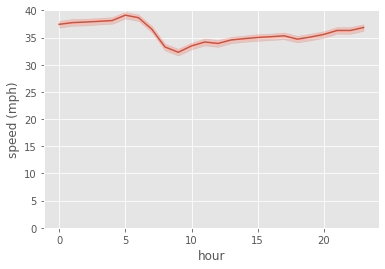

In [6]:
# modeled_oakland_vmt_24_hour = model_vmt_24_hour.loc[model_vmt_24_hour['NAME'] == 'Alameda']
demand_scaling = 1/percent_of_samples
print(demand_scaling)
model_vmt_24_hour.loc[:, 'VMT'] = demand_scaling * meter_to_mile * model_vmt_24_hour.loc[:, 'linkLength'] * model_vmt_24_hour.loc[:, 'volume']
# model_vmt_24_hour.loc[:, 'travel_time (hr)'] = model_vmt_24_hour.loc[:, 'linkLength'] /3600

model_vmt_24_hour.loc[:, 'speed'] = model_vmt_24_hour.loc[:, 'linkLength'] / model_vmt_24_hour.loc[:, 'traveltime'] 
model_vmt_24_hour.loc[:, 'speed (mph)'] = mps_to_mph * model_vmt_24_hour.loc[:, 'speed']
model_vmt_24_hour.loc[:, 'volume'] *= demand_scaling
sns.lineplot(x = 'hour', y = 'speed (mph)', data = model_vmt_24_hour, ci = 95)
plt.ylim([0, 40])
plt.savefig('plot/' + scenario_name + '/modeled_speed_for_all_links.png', dpi = 200)
plt.show()


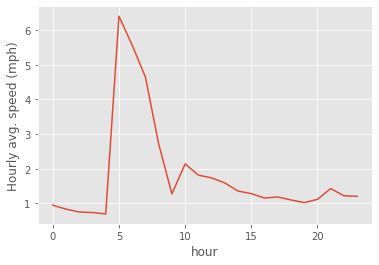

In [7]:
# SUMMARIZE HOURLY SPEED
model_vmt_24_hour.loc[:, 'VMT'] =  meter_to_mile * model_vmt_24_hour.loc[:, 'linkLength'] * model_vmt_24_hour.loc[:, 'volume']
model_vmt_24_hour.loc[:, 'VHT'] =  model_vmt_24_hour.loc[:, 'traveltime'] * model_vmt_24_hour.loc[:, 'volume'] / 3600.0
model_avg_speed = model_vmt_24_hour.groupby('hour')[['VMT','VHT']].sum()
model_avg_speed = model_avg_speed.reset_index()
model_avg_speed.loc[:, 'speed'] = model_avg_speed.loc[:, 'VMT'] / model_avg_speed.loc[:, 'VHT']
model_avg_speed.to_csv('sample output/' + scenario_name + '/avg_speed_whole_network.csv', sep = ',', index = False)
sns.lineplot(x = 'hour', y = 'speed', data = model_avg_speed, ci = None)
# plt.ylim([0, 40])
plt.ylabel('Hourly avg. speed (mph)')
plt.savefig('plot/' + scenario_name + '/avg_speed_for_all_links.png', dpi = 200)
plt.show()

In [8]:
# create 24 pivot table for speed and volume
speed_by_hour = pd.pivot_table(model_vmt_24_hour, values='speed (mph)', 
                               index=['linkId', 'fromNodeId', 'toNodeId'],
                    columns=['hour'])
speed_by_hour.columns = ['speed_' + str(i+1) for i in range(24)]
speed_by_hour = speed_by_hour.reset_index()
# print(speed_by_hour.head(5))

volume_by_hour = pd.pivot_table(model_vmt_24_hour, values='volume', 
                               index=['linkId', 'fromNodeId', 'toNodeId'],
                    columns=['hour'])
volume_by_hour.columns = ['volume_' + str(i+1) for i in range(24)]
volume_by_hour = volume_by_hour.reset_index()

combined_metric_by_hour = pd.merge(speed_by_hour, volume_by_hour, 
                                   on = ['linkId', 'fromNodeId', 'toNodeId'],
                                    how = 'outer')
combined_metric_by_hour.head(5)
combined_metric_by_hour.to_csv('sample output/' + scenario_name + '/processed_linkstats.csv', 
                               sep = ',', index = False)

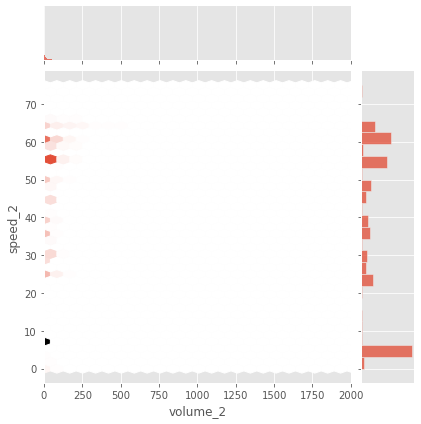

In [10]:
sns.jointplot(x = 'volume_2', y = 'speed_2', kind="hex", data = combined_metric_by_hour)
plt.xlim([0,2000])
plt.show()

In [10]:
observed_vmt.loc[:, 'DVMT'] = meter_to_mile * observed_vmt.loc[:, 'AADT'] * observed_vmt.loc[:, 'length']
observed_vmt.loc[:, 'DTRKVMT'] = meter_to_mile * (observed_vmt.loc[:, 'AADT_Singl']  + observed_vmt.loc[:, 'AADT_Combi']) * observed_vmt.loc[:, 'length']
observed_vmt.loc[:, 'PVMT'] = observed_vmt.loc[:, 'DVMT'] - observed_vmt.loc[:, 'DTRKVMT']

In [11]:
# assign roadway classification to modeled network, 
# ref: https://wiki.openstreetmap.org/wiki/User:UltimateRiff/HFCS
modeled_roadtype = model_vmt_24_hour.attributeOrigType.unique()
modeled_roadtype_lookup = {'tertiary': 'Minor collector',
                           'trunk_link': 'Freeway and major arterial',
                           'residential': 'Local',
                           'track': 'Local',
                           'footway': 'Local',
                           'motorway': 'Freeway and major arterial',
                           'secondary': 'Major collector',
                           'unclassified': 'Local',
                           'path': 'Local',
                           'secondary_link': 'Major collector',
                           'primary': 'Minor arterial',
                           'motorway_link': 'Freeway and major arterial',
                           'primary_link': 'Minor arterial',
                           'trunk': 'Freeway and major arterial',
                           'pedestrian': 'Local',
                           'tertiary_link': 'Minor collector',
                           'cycleway': 'Local',
                           np.nan: 'Local',
                           'steps': 'Local',
                           'living_street': 'Local', 
                           'bus_stop': 'Local',
                           'corridor': 'Local', 
                           'road': 'Local',
                           'bridleway': 'Local'}

observed_roadtype_lookup = {1: 'Freeway and major arterial',
                            2: 'Freeway and major arterial',
                            3: 'Freeway and major arterial',
                            4: 'Minor arterial',
                            5: 'Major collector',
                            6: 'Minor collector',
                            7: 'Local'}
model_vmt_24_hour.loc[:, 'road_class'] = model_vmt_24_hour.loc[:, 'attributeOrigType'].map(modeled_roadtype_lookup)
observed_vmt.loc[:, 'road_class'] = observed_vmt.loc[:, 'F_System'].map(observed_roadtype_lookup)
observed_oakland_vmt = observed_vmt.loc[observed_vmt['NAME'] == 'Alameda']
# print(modeled_roadtype)

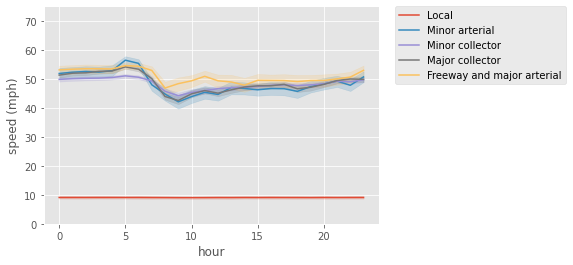

In [12]:
sns.lineplot(x = 'hour', y = 'speed (mph)', hue = 'road_class',
             data = model_vmt_24_hour, ci = 98)
plt.ylim([0, 75])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('plot/' + scenario_name + '/modeled_speed_by_roadtype.png', dpi = 200, bbox_inches= 'tight')
plt.show()

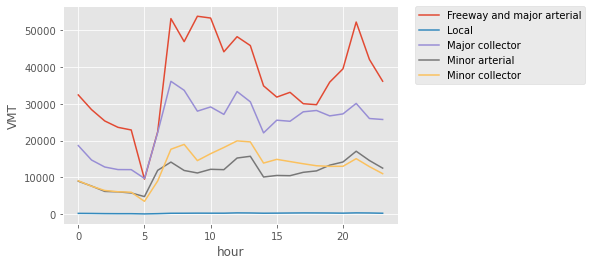

In [13]:
model_vmt_by_hour_roadtype = model_vmt_24_hour.groupby(['hour', 'road_class'])[['VMT']].sum()
model_vmt_by_hour_roadtype = model_vmt_by_hour_roadtype.reset_index()
sns.lineplot(x = 'hour', y = 'VMT', hue = 'road_class',
             data = model_vmt_by_hour_roadtype, ci = None)
# plt.ylim([0, 75])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('plot/' + scenario_name + '/modeled_VMT_by_hour_roadtype.png', dpi = 200, bbox_inches= 'tight')
plt.show()

In [14]:
model_vmt_24_hour_nolocal = model_vmt_24_hour.loc[model_vmt_24_hour['road_class'] != 'Local']
model_vmt_by_county = model_vmt_24_hour_nolocal.groupby(['NAME'])[['VMT']].sum()
model_vmt_by_county = model_vmt_by_county.reset_index()
model_vmt_by_county

observed_vmt_by_county = observed_vmt.groupby('NAME')[['PVMT']].sum()
observed_vmt_by_county = observed_vmt_by_county.reset_index()
observed_vmt_by_county

,NAME,PVMT
0,Alameda,2.936567e+06


modeled_VMT     2.039642e+06
observed_VMT    2.936567e+06
dtype: float64


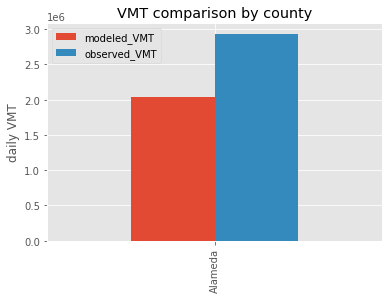

In [15]:
VMT_comparison = pd.merge(model_vmt_by_county, observed_vmt_by_county, 
                          on = 'NAME', how = 'left')
VMT_comparison = VMT_comparison.loc[:, ['NAME', 'VMT', 'PVMT']]
VMT_comparison.columns = ['county', 'modeled_VMT', 'observed_VMT']
print(VMT_comparison.loc[:, ['modeled_VMT', 'observed_VMT']].sum())

VMT_comparison.plot.bar(x = 'county')
plt.xlabel('')
plt.ylabel('daily VMT')
plt.title('VMT comparison by county')
plt.savefig('plot/' + scenario_name + '/VMT_comparison_by_county.png', dpi = 200, bbox_inches = 'tight')
plt.show()

In [16]:
model_vmt_by_roadtype = model_vmt_24_hour.groupby(['road_class'])[['VMT']].sum()
model_vmt_by_roadtype = model_vmt_by_roadtype.reset_index()
observed_vmt_by_roadtype = observed_vmt.groupby(['road_class'])[['PVMT']].sum()
observed_vmt_by_roadtype = observed_vmt_by_roadtype.reset_index()
VMT_comparison_by_roadtype = pd.merge(model_vmt_by_roadtype, observed_vmt_by_roadtype, 
                          on = 'road_class', how = 'left')
# VMT_comparison = VMT_comparison.loc[:, ['name', 'VMT', 'PVMT']]
VMT_comparison_by_roadtype.columns = ['road_class', 'modeled_VMT', 'observed_VMT']
VMT_comparison_by_roadtype

,road_class,modeled_VMT,observed_VMT
0,Freeway and major arterial,876160.321567,1.968016e+06
1,Local,5931.030111,NaN
2,Major collector,585452.861863,2.853819e+05
3,Minor arterial,269898.133572,6.830797e+05
4,Minor collector,308130.374300,8.875103e+01


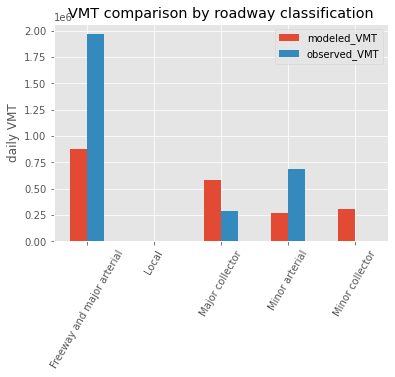

In [17]:
VMT_comparison_by_roadtype.plot.bar(x = 'road_class')
plt.xlabel('')
plt.ylabel('daily VMT')
plt.title('VMT comparison by roadway classification')
plt.xticks(rotation = 60)
plt.savefig('plot/' + scenario_name + '/VMT_comparison_by_roadway_type.png', dpi = 200, bbox_inches = 'tight')
plt.show()

/var/folders/w6/7qcyt43n21ddydhdfdslrp7c0000gp/T/ipykernel_34566/2897943063.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks()])


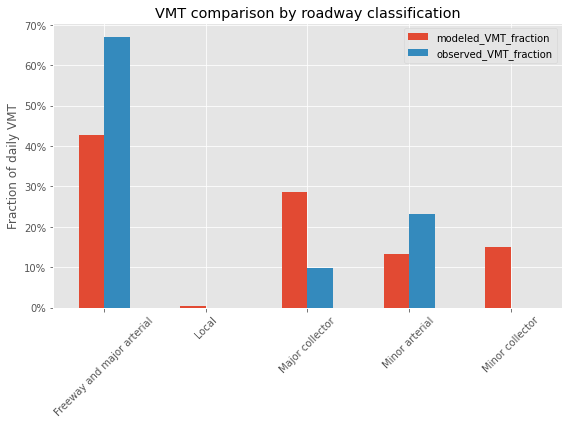

In [18]:
VMT_comparison_by_roadtype.loc[:, 'modeled_VMT_fraction'] = VMT_comparison_by_roadtype.loc[:, 'modeled_VMT'] / VMT_comparison_by_roadtype.loc[:, 'modeled_VMT'].sum()
VMT_comparison_by_roadtype.loc[:, 'observed_VMT_fraction'] = VMT_comparison_by_roadtype.loc[:, 'observed_VMT'] / VMT_comparison_by_roadtype.loc[:, 'observed_VMT'].sum()
percent_VMT_comparison_by_roadtype = VMT_comparison_by_roadtype.loc[:, ['road_class', 'modeled_VMT_fraction', 'observed_VMT_fraction']]

import matplotlib.ticker as mtick
# plt.figure(figsize = (12,8))
ax = percent_VMT_comparison_by_roadtype.plot.bar(x = 'road_class',figsize = (8,6))
# ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.xlabel('')
plt.xticks(rotation = 45)
ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks()]) 
# vals = ax.get_yticks()
# ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.ylabel('Fraction of daily VMT')
plt.title('VMT comparison by roadway classification')
plt.tight_layout()
plt.savefig('plot/' + scenario_name + '/percent_VMT_comparison_by_roadway_type.png', dpi = 200)
plt.show()

<AxesSubplot:xlabel='attributeOrigType'>

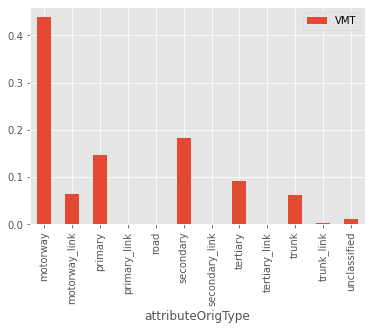

In [19]:
model_vmt_by_osmtype = model_vmt_24_hour.groupby(['attributeOrigType'])[['VMT']].sum()
model_vmt_by_osmtype.loc[:, 'VMT'] /= model_vmt_by_osmtype.loc[:, 'VMT'].sum()
model_vmt_by_osmtype.plot.bar()